# DS3000 Final Project: Hate speech on Twitter
## Team 8

- Meera Whitson whitson.m@northeastern.edu
- Anthony Bernardi bernardi.an@northeastern.edu

#### Reuse Permissions

The following may be re-used for any purposes:
- all data included with submission
- all images
- this report and the notebooks which collected / cleaned the data
- the associated [video presentation](https://www.youtube.com/watch?v=S_URBIPFRK4)

Please attribute any work to the authors listed above.

### CONTENT WARNING: offensive language


# Executive Summary

We constructed a classifier for hate speech on Twitter using a labeled dataset of Tweets. Originally, we had hoped to scrape Tweets ourselves, but we then [realized we needed labeled data](#switching_datasets) so began using a dataset from Kaggle. This dataset only contained labels and the text of the Tweet, so we used NLP techniques (bag-of-words) to [create our own features out text.](#method) We trained a random forest classifier and evaluated it using ten-fold cross validation, which showed that our classifier avoided any false positives, but failed to correctly identify the majority of the hateful Tweets, as shown in this [confusion matrix](#matrix). Our results demonstrate that using a bag-of-words approach and just looking at vocabulary is [inadequate](#limitations) for hate speech detection, so we recommend that future research explore more advanced NLP models. However, hate speech detection has lots of ethical considerations, so any applications which will be used in the real world need to be incredibly careful about [preventing biases](#takeaway) in the models.

# Ethical Considerations

The point of a hate speech classifier is to classify online posts and detect hateful language that are missed by manual review. Thus, it is intended to evaluate pretty much everything that is posted online. This does raise some ethical issues as it would increase surveillance on individuals' speech. 

Additionally, hate speech classifiers that are currently in use by Twitter and other media companies have been shown to be biased against many minority groups, particularly speakers of African American Vernacular English (AAVE). Biases such as these have been repeatedly documented and reported on:

- [The algorithms that detect hate speech online are biased against black people](https://www.vox.com/recode/2019/8/15/20806384/social-media-hate-speech-bias-black-african-american-facebook-twitter)
- [Google’s Artificial Intelligence Hate Speech Detector Has a ‘Black Tweet’ Problem](https://observer.com/2019/08/google-ai-hate-speech-detector-black-racial-bias-twitter-study/)
- [Study finds racial bias in tweets flagged as hate speech](https://news.cornell.edu/stories/2019/08/study-finds-racial-bias-tweets-flagged-hate-speech)

Many models that are currently being used by Twitter, Google, and other platforms are predisposed to tag AAVE as offensive because some typical features of AAVE may be features of offensive language in standard/ white American English, as shown in the slide below (credit to Professor Felix Muzny).

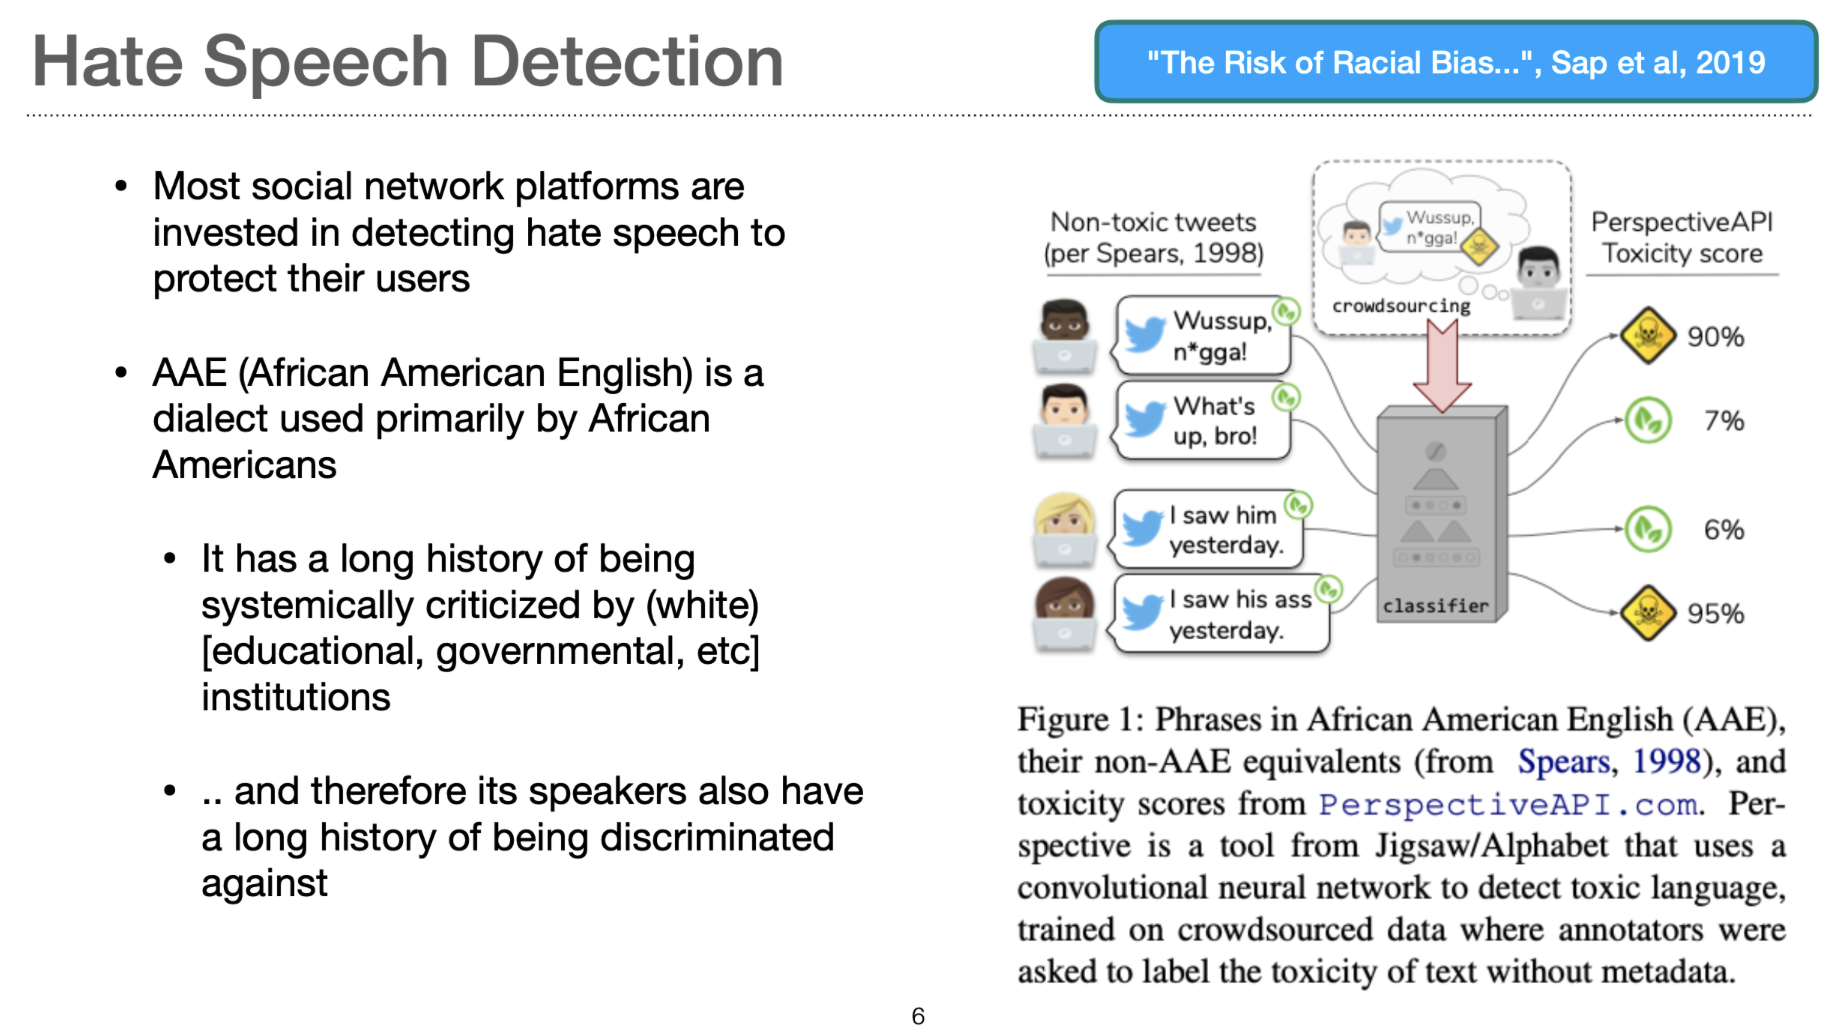

Speech classifiers will always struggle with speech that is considered "nonstandard" by the model, so it is incredibly important to not only make sure to supply models with diverse training data, but also to take into account variable such as the identity of the speaker in order to not misidentify text as hate speech. Once again, this raises an ethical concern due to privacy issues, because we don't want to collect too much personal information on users without their informed consent.

Additionally, the definition of hate speech is somewhat subjective. Linguistic research uses a few different definitions. For this project, we will be using the definition provided by Alexandria Marsters:
- "“a problematic expressive speech act which conveys derogatory sentiment towards a person or persons based on the perceived possession of a socially defined group characteristic, which is made to the detriment of the target, and is addressed to the ingroup with the intention of inciting animus and/or violence or is addressed to the target with the effect of instilling a fear of violence or harm” (Marsters, 65-66).
    
Even with this thorough definition, individual people will disagree on what is and isn't hate speech, and infringement on free speech is a real concern. We don't want to to develop a model that censors any controversial topic or discussion of race and identity, but it is a challenge to define a line between a valid opinion and hateful language, especially if we are trying to use an automated system instead of having real people evaluate posts. This is a nuance that will definitely be a big challenge to program, but should absolutely be considered before any such models are used in the real world.

Ethics are a big concern for this project, but classifying hate speech is still an important enough issue that we believe it is necessary to try to improve these models. Because of that and biases mentioned above, it is crucial to consider differences in dialect and speaker identity so that oppression of minority groups is not perpetuated by models such as these.


# Introduction

As the number of internet users grows drastically, the need to monitor hateful content has exceeded the capabilities of individual tech companies. This has had an incredible amount of adverse effects, from rhetoric posted on Facebook fueling the genocide against the Rohingya in Myanmar to the creation of echo chambers in our news feed that has drastically increased the ease with which people are radicalized. Twitter has recently taken actions such as banning Donald Trump from the platform, but there are certainly still issues remaining. Training algorithms and models to catch language like this can prevent issues from escalating further into action that will hurt people, and it is becoming increasingly necessary as internet use becomes more pervasive. Many computer scientists and social scientists have done research on online hate speech including [this group](https://developer.twitter.com/en/use-cases/success-stories/hatelab) which is featured on the Twitter Developer website.

Here are some published academic papers discussing hate speech on Twitter that have inspired this project:

- Waseem, Z., & Hovy, D. (2016). Hateful symbols or hateful people? Predictive features for hate speech detection on twitter. Proceedings of the NAACL Student Research Workshop, 88-93. doi:10.18653/v1/n16-2013
- Gambäck, B., & Isaksen, V. (2020). Using Transfer-based Language Models to Detect Hateful and Offensive Language Online. Proceedings of the Fourth Workshop on Online Abuse and Harms. doi:10.18653/v1/2020.alw-1.3
- Saleh, H., Alhothali, A., & Moria, K. (2020). Detecting White Supremacist Hate Speech using Domain Specific Word Embedding with Deep Learning and BERT. ArXiv. Retrieved 2021, from https://arxiv.org/pdf/2010.00357.pdf.
- Marsters, A. (2019). When Hate Speech Leads to Hateful Actions: A Corpus and Discourse Analytic Approach to Linguistic Threat Assessment of Hate Speech. DigitalGeorgetown. Retrieved 2021, from https://repository.library.georgetown.edu/bitstream/handle/10822/1056009/Marsters_georgetown_0076D_14371.pdf?sequence=1&isAllowed=y.


In order to use data science to solve this problem, we want to develop a classifier that can identify hate speech. If Twitter and other social media platforms can implement effective classifiers that can catch and eliminate hate speech before it reaches a wide audience, then violence and other harm to oppressed populations could be prevented.

In [1]:
# consolidating import statements
from collections import Counter
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, r2_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Data Description

For this project, we scraped and cleaned data from Twitter ourselves, as shown in the dataframe below. The data we stored for each tweet includes the following:
- the term that was flagged
- hashtags
- number of likes
- number of retweets
- screen name of author
- username/ @ of author
- user bio
- user location
- tagged as sensitive by Twitter?
- text body of Tweet
- time Tweet was posted
- Tweet id number
- Tweet location

The pipeline we constructed to collect this data is shown in the Twitter scraping notebook (data_collection_twitter_scraping.ipynb).

In [2]:
import pandas as pd

df_scraped = pd.read_csv("flagged_tweets.csv")
df_scraped.head()

,Unnamed: 0,flagged term,hashtags,likes,name,possibly sensitive,retweets,screen name,text,time,tweet id,tweet location,user bio,user location
0,0,uncivilised,[],1.0,Quincunx,NaN,0.0,Quincun36705461,@dcvandiver @nancycruise1 uncivilised is how i...,Tue Mar 23 00:34:49 +0000 2021,1.374158e+18,NaN,One of the silent majority who will not be sil...,NaN
1,1,uncivilised,[],5.0,British border in Ireland -Irish did’nt make it.,NaN,0.0,border_ireland,@conormlally @ChrisMcNultyDgl Did you consider...,Tue Mar 23 00:14:01 +0000 2021,1.374152e+18,NaN,"It’s not an Irish border, Irish didn’t put it ...",The Border
2,2,uncivilised,[],1.0,evil_gnome 🍄,NaN,0.0,gnome_196883,@frontwheelskid They are supposed to be diplom...,Mon Mar 22 23:51:01 +0000 2021,1.374147e+18,NaN,When I'm not sitting in front of a computer I ...,🇬🇧 🇲🇰 🇪🇪
3,3,uncivilised,[],6.0,Peter 😷,NaN,0.0,pbmosligo,@Andrewm05562037 @JoeBrolly1993 What has no pl...,Mon Mar 22 23:30:44 +0000 2021,1.374142e+18,NaN,- politics - current affairs - well being - bu...,Ireland
4,4,uncivilised,[],1.0,Loop PNG,False,0.0,looppng,Southern Command’s Assistant Commissioner of P...,Mon Mar 22 23:14:06 +0000 2021,1.374137e+18,NaN,Loop is PNG's #1 digital news source for local...,Papua New Guinea


In order to visualize this data better, we created a bar graph displaying the terms that received the most likes. 

### CONTENT WARNING: offensive language

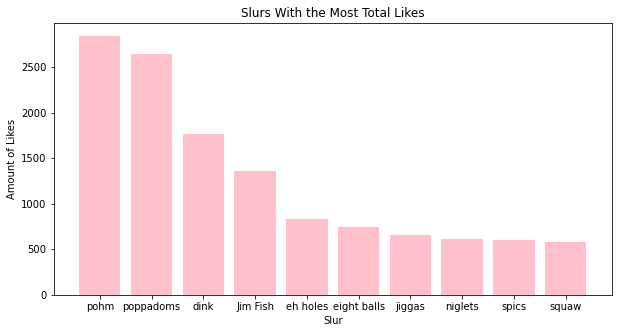

In [3]:
# get all the unique slurs and make an empty dictionary
slurs = set(df_scraped['flagged term'])
likes_dict = {}

# for every slur
for slur in slurs:
    # get hate speech just of that flagged term
    series_bool = df_scraped['flagged term'] == slur
    df_flagged_term = df_scraped.loc[series_bool, :]
    
    # sum the total likes then add it to the dictionary
    total_likes = np.sum(df_flagged_term['likes'])
    likes_dict[slur] = total_likes

# https://stackoverflow.com/questions/16010869/plot-a-bar-using-matplotlib-using-a-dictionary
# I used this link to help me plot the dictionary
x_values = np.array(list(likes_dict.keys()))
y_values = np.array(list(likes_dict.values()))

# sort them from biggest to smallest
inds = y_values.argsort()
sorted_x = np.flip(x_values[inds])
sorted_y = np.flip(y_values[inds])

# graph the first ten
plt.bar(sorted_x[:10], sorted_y[:10], align='center', color='pink')
plt.gcf().set_size_inches(10, 5)

plt.title('Slurs With the Most Total Likes')
plt.xlabel('Slur')
plt.ylabel('Amount of Likes')

f = 'most_liked_slurs.pdf'
with PdfPages(f) as pdf:
    pdf.savefig(bbox_inches='tight')

<a id='switching_datasets'></a>
## Switching datasets


We decided that this dataframe contained a lot of false positives, and we needed more reliable, labeled data in order to construct a useable classifier. Thus, for our ML step, we decided to pivot and use a dataset from Kaggle, linked [here](https://www.kaggle.com/arkhoshghalb/detecting-hate-tweets?select=train.csv). This dataset has 32 thousand tweets which hav been prelabeled for us with a 1 for a hateful Tweet or a 0 for a non-hateful Tweet. The dataframe is shown below. This dataset contains much less information: just an integer ID number, an integer label, and the body of the Tweet as a string. The Kaggle link also supplies a test file, but this is not labeled, so we do not use it for our analysis because there is no way to check accuracy using ML techniques.

In [4]:
df_kaggle = pd.read_csv('hate_speech_train.csv', index_col='id')
df_kaggle[0:20]

,label,tweet
id,,
1,0,@user when a father is dysfunctional and is s...
2,0,@user @user thanks for #lyft credit i can't us...
3,0,bihday your majesty
4,0,#model i love u take with u all the time in ...
5,0,factsguide: society now #motivation
6,0,[2/2] huge fan fare and big talking before the...
7,0,@user camping tomorrow @user @user @user @use...
8,0,the next school year is the year for exams.ð...
9,0,we won!!! love the land!!! #allin #cavs #champ...


Text of Tweet 14 for an example of something that was labeled as hateful:
- "@user #cnn calls #michigan middle school 'build the wall' chant '' #tcot  "

One important limitation to consider with this dataset is we don't know how the data was labeled. We do not have information the criteria used to qualify something as hate speech or not, and we do not know who labeled it. Additionally, we do not know how the dataset was collected in the first place, so it is difficult to extrapolate our findings to all of Twitter or the internet as a whole.

Because this dataset only has labels and text, there is not really anything we can graph. Even after we create futures using NLP techniques (shown below), there aren't many useful visualizations we can make due to the nature of the data. 

There is a significant class disparity in the data, which is shown in the pie chart below.

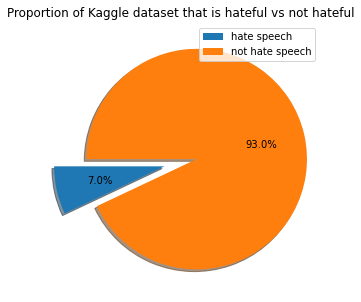

In [5]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'hate speech', 'not hate speech'

series_bool = df_kaggle['label'] == 1
df_hate_only = df_kaggle.loc[series_bool, :]

series_bool = df_kaggle['label'] == 0
df_not_hate = df_kaggle.loc[series_bool, :]

sizes = [len(df_hate_only), len(df_not_hate)]
explode = (0.3, 0)  

plt.title("Proportion of Kaggle dataset that is hateful vs not hateful")
plt.pie(sizes, explode=explode, autopct='%1.1f%%',
        shadow=True, startangle=180)
plt.axis('equal') 
plt.legend(labels)

plt.gcf().set_size_inches(5, 5)

f = 'class_disparity.pdf'
with PdfPages(f) as pdf:
    pdf.savefig(bbox_inches='tight')

# Method


<a id='method'></a>
### Creating our own features using NLP

Because our new dataframe has only three columns, we need to figure out how to get features from what we have. For this, we will be using some natural language processing (NLP) techniques, specifically bag-of-words. This means we will keep track of every word that occurs in a hate tweet in the training set and how often it appears, same for every word that occurs in a non-hate tweet. We end up with two separate sets of words and probabilities. From this, we can find the most common words in each class (hate speech / not hate speech) and use these as features to look for in test Tweets.

Adding these features to the dataframe increases the size by a lot. We decided to limit our features to the 5000 most common words in the hate speech class, minus words that are equally common in the not hate speech class, in order to remove words that are just common in general, such as "the", "I", and "@user" (usernames are anonymized in the dataset). We end up with a dataframe with 4020 columns, including the hate speech label and the Tweet body, so we created 4018 features out of no features by using these NLP techniques.

__These features are added in data_collection_cleaning_kaggle_dataset.ipynb, but we are repeating it here due to space constraints. We can't save it to a csv because it is over 500 MB.__

We are not printing out the dataframes here so as not to clutter the report with redundant information about data cleaning.

In [6]:
# set up dictionary for all the unique words
unique_words = dict()

# do hate and not hate words
hate_words = dict()
not_hate_words = dict()

# for every tweet that is hate speech
for tweet in df_hate_only['tweet']:
    # get the words in the tweet
    words = tweet.split()
    
    # for each word in the tweet
    for word in words:
        # count it in the dictionary
        if word in hate_words:
            hate_words[word] += 1
        else:
            hate_words[word] = 1
            
# for every tweet that is not hate speech
for tweet in df_not_hate['tweet']:
    # get the words in the tweet
    words = tweet.split()
    
    # for each word in the tweet
    for word in words:
        # count it in the dictionary
        if word in not_hate_words:
            not_hate_words[word] += 1
        else:
            not_hate_words[word] = 1

# for each key in value in hate speech, if it is not also in non-hate speech we add it to the total words
for k, v in hate_words.items():
    if not (k in not_hate_words):
        unique_words[k] = v
        
# make a counter out of it          
unique_words_counter = Counter(unique_words)

# now we can get the 5000 most common words
most_common = unique_words_counter.most_common(5000)

# make a new df to not mess things up
df_words = df_kaggle.copy()

# get the x_feat_list
x_feat_list = [x[0] for x in most_common]

# for each word, add it to the dataframe as a list of 0's
for word in x_feat_list:
    if word != 'tweet' and word != 'label':
        df_words[word] = np.zeros(len(df_kaggle['tweet']))
        
# turn this into a dictionary so we can search for things in O(1) time
most_common_dict = dict()

for k, v in most_common:
    most_common_dict[k] = v
    
# make a new dataframe so we don't mess things up
df_words_copy = df_words.copy()

# for each tweet
for index in df_words_copy.index:
    # get the words in the tweet
    tweet = df_words_copy.loc[index, 'tweet']
    words = tweet.split()
    
    # for each word
    for word in words:
        # if it is one of the features, make it 1 for this row
        if word in most_common_dict:
            df_words_copy.loc[index, word] = 1

### Analyzing features

Now that we have these features, we need to analyze them using ML methods. Based on everything we've done in lectures and in homeworks thus far, we believe that Random Forest Analysis would be the best method for this project in order to minimize the chance of overfitting. Random forest classifiers use multiple instances of decision trees, making them less vulnerable to mistakes and better at determining correlations between features and labels. [Here](https://towardsdatascience.com/understanding-random-forest-58381e0602d2) is an overview of random forests and why they are incredibly effective ML tools for classification. One considerable downfall of using a random forest classifier is the time it takes to train, especially because we have over four thousand features, but it does not take unreasonably long, so we think it's worth it.

We also want to determine how reliable looking at vocabulary is for determining class membership. Like mentioned before, we determine what words to use as features by finding the most common words in the hate class and then subtracting out the ones that are also among the most common words in the non hate class, but what if we did not remove these? We wanted to figure out how similar the words used in each class are, so we will construct a heat map comparing the most common words in each class. This is important because vocabulary is not the best indicator of whether the content of a Tweet is hateful or not, as has been demonstrated in previous linguistic and NLP research. Simply looking at words that do or do not appear in a Tweet does not reveal a lot about the meaning behind a Tweet, so we expect to see a decent amount of overlap in the vocabularies of each class. This implies that more advanced NLP techniques would be better than bag-of-words, which would be a good starting point for continued research on this subject.

# Results

Due to significant class disparities in the data (approximately 2k examples of hate speech and 30k examples of not hate speech), we constructed a modified dataframe called df_even which contains a more even split of the two classes (3k examples of not hate speech and all 2k examples of hate speech). The reasoning for this is that the imbalances in class size were preventing our models from predicting the hate speech label at all due to how rare it was in the training data.


We trained a random forest classifier using 10-fold cross validation. To evaluate the success of this classifier, we constructed a confusion matrix, which compares the labels predicted by our model to the true labels of Tweets.

In [7]:
# constructing df_even

hate_bool = df_words_copy['label'] == 1
not_hate_bool = df_words_copy['label'] == 0

df_only_hate = df_words_copy.loc[hate_bool, :]
df_only_not_hate = df_words_copy.loc[not_hate_bool, :]

df_even = df_only_hate.append(df_only_not_hate.iloc[:3000])

df_even.head()

,label,tweet,#allahsoil,#sjw,if...,#miamiâ¦,#sikh,#bigot,vandalised,"#calgary,",...,mall.,omfg,offended!,#mailboxpride,#liberalisme,weasel,tony..,dipshit.,anybody?,....god
id,,,,,,,,,,,,,,,,,,,,,
14,1,@user #cnn calls #michigan middle school 'buil...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,1,no comment! in #australia #opkillingbay #se...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18,1,retweet if you agree!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,1,@user @user lumpy says i am a . prove it lumpy.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35,1,it's unbelievable that in the 21st century we'...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train a random forest and make a confusion matrix:

In [8]:
y_feat = 'label'

# extract data from dataframe
x = df_even.loc[:, x_feat_list].values
y = df_even.loc[:, y_feat].values

In [9]:
# make the random forest and fit i
rf_clf = RandomForestClassifier(max_depth=100)

# build the kfold with 10 folds
kfold = StratifiedKFold(n_splits=10)

# initialize an empty array same size as y_true
y_pred = np.empty_like(y)

# for each fold
for train_idx, test_idx in kfold.split(x, y):
    # get training data
    x_train = x[train_idx, :]
    y_true_train = y[train_idx]

    # get testing data
    x_test = x[test_idx, :]
    y_true_test = y[test_idx]

    # train the random forest on training data
    rf_clf.fit(x_train, y_true_train)

    # estimate whether hate speech or not
    y_pred[test_idx] = rf_clf.predict(x_test)

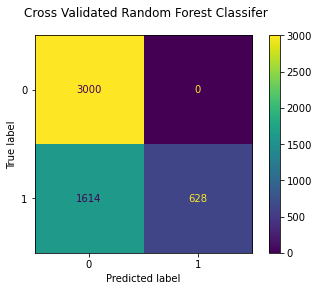

In [10]:
# compute confusion matrix
conf_mat = confusion_matrix(y_true=y, y_pred=y_pred)

# plot confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y))
sns.reset_orig()
conf_mat_disp.plot()
plt.suptitle('Cross Validated Random Forest Classifer')

f = 'matrix_df_even.pdf'
with PdfPages(f) as pdf:
    pdf.savefig(bbox_inches='tight')

Our model correctly identifies every non hate speech Tweet as not hate speech and about a quarter of the hate speech Tweets as hateful. This proportion changes a bit as we modify the depth of the random forest classifier. Interestingly, we do not have any false positives. This may be a result of our model overfitting, but it could be good considering false positives are a huge problem for hate speech classifiers, as discussed in the ethical considerations section, so we do want to minimize the amount of false positives.  However, this classifier also fails to identify a considerable amount of hate speech, which is another issue. We expect it will take a more sophisticated model (more advanced NLP techniques) to strike a balance between the two.

We trained our classifier on df_even, but we want to test how it performs on the entire dataset (with all 30k non hate Tweets), so we once again ran the ten-fold cross validation, this time on the entire dataset. Due to the huge class disparities, the colors on this matrix are a bit misleading. It actually correctly identifies more hateful Tweets, which is interesting because the main dataset and df_even have the exact same number of hateful Tweets. Once again, there are no false positives, which is interesting. 

<a id='matrix'></a>

### Confusion matrix for the entire dataset:

In [11]:
# extract data from dataframe
x_full = df_words_copy.loc[:, x_feat_list].values
y_full = df_words_copy.loc[:, y_feat].values


y_pred_full = rf_clf.predict(x_full)
y_true_full = df_words_copy['label']

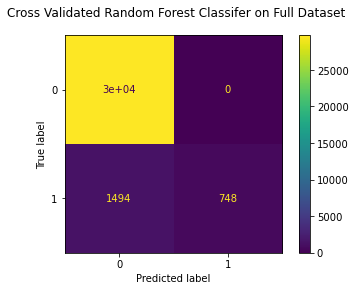

In [12]:
# compute confusion matrix
conf_mat = confusion_matrix(y_true=y_true_full, y_pred=y_pred_full)

# plot confusion matrix
conf_mat_disp = ConfusionMatrixDisplay(conf_mat, display_labels=np.unique(y_full))
sns.reset_orig()
conf_mat_disp.plot()
plt.suptitle('Cross Validated Random Forest Classifer on Full Dataset')

f = 'matrix_entire_dataset.pdf'
with PdfPages(f) as pdf:
    pdf.savefig(bbox_inches='tight')

### Feature importance

We wanted to analyze feature importance for our classifier. However, we think the fact that we have over 4000 features means that none of them are particularly important. We're using a function from lecture to plot feature importance, and nothing is plotted on the graph. We attribute this to no one particular feature standing out as particularly important when compared to the rest of the features.

In [13]:
def plot_feat_import(feat_list, feat_import, sort=True, limit=None):
    """ plots feature importances in a horizontal bar chart
    Args:
        feat_list (list): str names of features
        feat_import (np.array): feature importances (mean gini reduce)
        sort (bool): if True, sorts features in decreasing importance
                from top to bottom of plot
        limit (int): if passed, limits the number of features shown
                to this value    
    """
    
    if sort:
        # sort features in decreasing importance
        idx = np.argsort(feat_import).astype(int)
        feat_list = [feat_list[_idx] for _idx in idx]
        feat_import = feat_import[idx] 
        
    if limit is not None:
        # limit to the first limit feature
        feat_list = feat_list[:limit]
        feat_import = feat_import[:limit]

    # plot and label feature importance
    plt.barh(feat_list, feat_import)
    plt.gcf().set_size_inches(10, len(feat_list) / 2)
    plt.xlabel('Feature importance\n(% decrease in Gini due to each feature)')

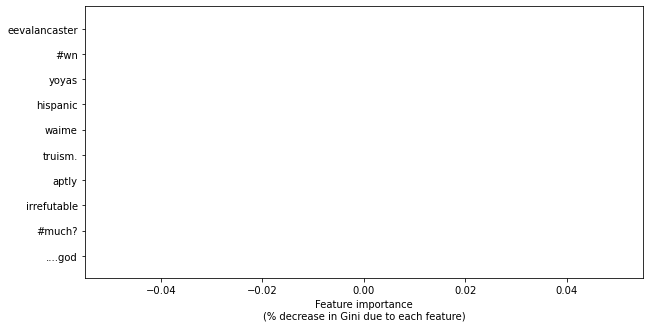

In [14]:
plot_feat_import(x_feat_list, rf_clf.feature_importances_, limit=10)

f = 'attempted_feat_import_graph.pdf'
with PdfPages(f) as pdf:
    pdf.savefig(bbox_inches='tight')

# Discussion

Overall, we have found that hate speech detection is doable, but difficult to do well, and doing it well is essential. Our model is pretty elementary for an NLP application, and fails to identify a lot of hate speech. However, we have demonstrated enough successful identifications of hate speech to show that constructing features out of just words is a valid approach to classifying text, it just needs a lot more improvement before it could be applied in the real world. Additionally, like many machine learning applications, hate speech detection is extraordinarily vulnerable to bias, so the utmost care has to be taken when training models. The fact that we do not know a lot of information about our training data is a huge factor that prevents us from being incredibly confident in the ability of our model to have practical applications. Hopefully, researchers in the field of NLP already know this and are working to take this into account as hate speech detection algorithms are constantly designed and improved upon.

<a id='limitations'></a>
### Limitations 

We recognize that this project does face considerable limitations, including but not limited to the following:
1. We may be dealing with some overfitting 
    - The fact that our random forest classifier returned no false positives is a bit confusing, and could be attributed to our features being collected from the dataset itself, which might have led to overfitting.
2. We don’t know how the training dataset was labeled
    - The page on Kaggle from which we got this dataset does not contain any information on how these Tweets were labeled. We don't know if labels were assigned based on a definition similar to that published by Marsters (shown above). Thus, we don't really have a way to evaluate whether we trust the "true" labels of this data because we don't know where they came from.
3. Bag-of-words is a pretty simple NLP method
    - There are others that can analyze sequences of words to get a better grasp of meaning. Some of the research papers we read on the topic examined the applications of transfer learning models, deep learning, and other neural networks, including incredibly large architectures such as BERT. We could not reasonably implement these for this project, but this is certainly an area of research we hope that Twitter and other social media companies are exploring. 
4. No one has actually solved hate speech detection yet
    - Twitter and Facebook’s algorithms are still works in progress
    - NLP researchers (specifically Zeerak Waseem) have been working on this problem for years
    - People don’t always agree on what hate speech is, so it’s hard to train models to identify it. Even with a definition like Marsters's, individuals can make their own decisions on what is and isn't hate speech, and the line dividing the two classes can be different for everyone. Additionally, the training data given to models should be labeled by a diverse team representing many different dialects to account for biases against certain groups, as discussed in the ethical considerations section.

<a id='takeaway'></a>

### Takeaway
Hate speech detection is a topic that is in need of significantly more research. Developing these algorithms requires tremendous care because the risk that minority groups will be unfairly targeted by these algorithms needs to be minimized as much as possible to make sure that hate speech detection does not do more harm than good. Data scientists need to be careful to avoid infringing on the free speech of anyone, particularly those who have been repeatedly abused by systematic racism. Because of this, hate speech detection is delicate process.

We do not think our specific model should be applied to real world Tweets because there exist much better, more complicated models already. However, we feel that the need to improve hate speech detection is significant enough that media companies should invest resources into it, while taking as many precautions as possible to mitigate exacerbating biases and disadvantaging minority communities in the process.